In [1]:
import numpy as np
import matplotlib.pyplot as plt
import inference_interface as ii
from tqdm import tqdm

import pickle as pkl
from multihist import Histdd

import flamedisx as fd

import os

2024-11-07 05:31:42.030582: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730986302.044888  981854 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730986302.049313  981854 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 05:31:42.065534: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/global/homes/k/kdund/.conda/envs/flamedisx_xlzd/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not fou

In [2]:
pdfs = [dict(), dict()]

In [3]:
fd.__file__

'/global/homes/k/kdund/.conda/envs/flamedisx_xlzd/lib/python3.11/site-packages/flamedisx/__init__.py'

In [4]:
fd.__version__

'2.1.0'

## ROI for templates

In [5]:
xlzd_source = fd.xlzd.XLZDERSource(configuration='40t')

cS1_min = xlzd_source.cS1_min
cS1_max = xlzd_source.cS1_max
log10_cS2_min = xlzd_source.log10_cS2_min
log10_cS2_max = xlzd_source.log10_cS2_max

/global/homes/k/kdund/.conda/envs/flamedisx_xlzd/lib/python3.11/site-packages/flamedisx/source.py:271: UserWarning: Defaults for unused settings ignored: {'configuration': '40t'}
  warnings.warn(f"Defaults for unused settings ignored: {unused}")


In [10]:
detector_configuration = dict(
    configuration='40t',
    drift_field_V_cm=80., gas_field_kV_cm=7.5,
    elife_ns=10000e3,
    g1=0.27
)

sources = dict(
    SolarER = fd.xlzd.XLZDvERSource,
    Xe136   = fd.xlzd.XLZDXe136Source,
    Pb214 = fd.xlzd.XLZDPb214Source,
    Kr85 = fd.xlzd.XLZDKr85Source,
    CEvNS_solar = fd.xlzd.XLZDvNRSolarSource,
    CEvNS_other = fd.xlzd.XLZDvNROtherSource,

)
source_WIMP = fd.xlzd.XLZDWIMPSource
wimp_masses = [40.]
sources = {k:i(**detector_configuration) for k,i in sources.items()}
sources_wimp = {"WIMP{:.0f}".format(wimp_mass):source_WIMP(wimp_mass=wimp_mass,**detector_configuration) for wimp_mass in wimp_masses }
sources.update(**sources_wimp)

binning = dict(
    bins=[np.linspace(cS1_min, cS1_max,101),np.linspace(log10_cS2_min, log10_cS2_max,151)], 
    axis_names=['cS1', 'log10_cS2']
)
    
    


N_hist = int(1e8)
N_hist_batch = 100
N_mu = int(1e6)

/global/homes/k/kdund/.conda/envs/flamedisx_xlzd/lib/python3.11/site-packages/flamedisx/source.py:271: UserWarning: Defaults for unused settings ignored: {'configuration': '40t'}
  warnings.warn(f"Defaults for unused settings ignored: {unused}")
/global/homes/k/kdund/.conda/envs/flamedisx_xlzd/lib/python3.11/site-packages/flamedisx/source.py:271: UserWarning: Defaults for unused settings ignored: {'configuration': '40t'}
  warnings.warn(f"Defaults for unused settings ignored: {unused}")
/global/homes/k/kdund/.conda/envs/flamedisx_xlzd/lib/python3.11/site-packages/flamedisx/source.py:271: UserWarning: Defaults for unused settings ignored: {'configuration': '40t'}
  warnings.warn(f"Defaults for unused settings ignored: {unused}")
/global/homes/k/kdund/.conda/envs/flamedisx_xlzd/lib/python3.11/site-packages/flamedisx/source.py:271: UserWarning: Defaults for unused settings ignored: {'configuration': '40t'}
  warnings.warn(f"Defaults for unused settings ignored: {unused}")
/global/homes/k/

In [15]:
pdfs = dict()

In [16]:
for n,source in sources.items():
    print("filling ",n)
    hist = Histdd(**binning)
    for i in tqdm(range(N_hist_batch)):
        data = source.simulate(int(N_hist/N_hist_batch))
        hist.add(data["cs1"], np.log10(data["cs2"]))
    mu = source.estimate_mu(n_trials=N_mu)
    hist.histogram *= mu / hist.n
    #plt.clf()
    #hist.plot()
    #plt.title(n)
    #plt.show()
    pdfs[n] = hist

filling  SolarER


100%|██████████| 100/100 [02:22<00:00,  1.43s/it]


filling  Xe136


100%|██████████| 100/100 [02:08<00:00,  1.28s/it]


filling  Pb214


100%|██████████| 100/100 [02:11<00:00,  1.32s/it]


filling  Kr85


100%|██████████| 100/100 [02:08<00:00,  1.28s/it]


filling  CEvNS_solar


100%|██████████| 100/100 [01:42<00:00,  1.03s/it]


filling  CEvNS_other


100%|██████████| 100/100 [02:16<00:00,  1.36s/it]


filling  WIMP40


100%|██████████| 100/100 [02:26<00:00,  1.46s/it]


In [17]:
#plotting

## Save all PDFs

In [18]:
if not os.path.exists('PDFs'):
    os.makedirs('PDFs')

In [19]:
histogram_names = sorted(pdfs.keys())
#pdfs = [pdfs[k] for k in histogram_names]

In [20]:
fname = "PDFs/pdfs_{configuration:s}_finebin.ii".format(configuration=detector_configuration["configuration"])
ii.multihist_to_template(
    [pdfs[k] for k in histogram_names], 
    fname, 
    histogram_names = histogram_names, 
)

CEvNS_other 0.0003520068174432431


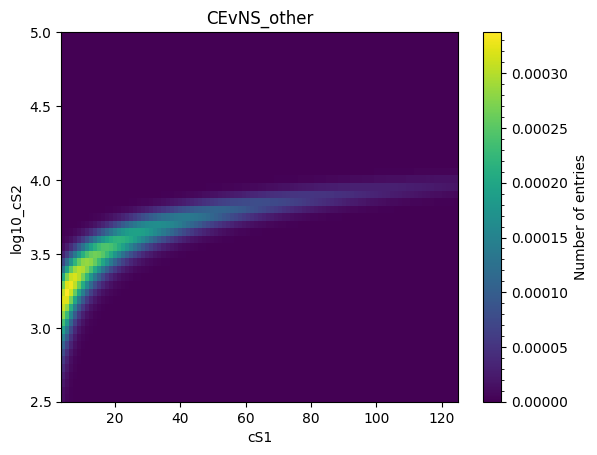

CEvNS_solar 0.02151647624947684


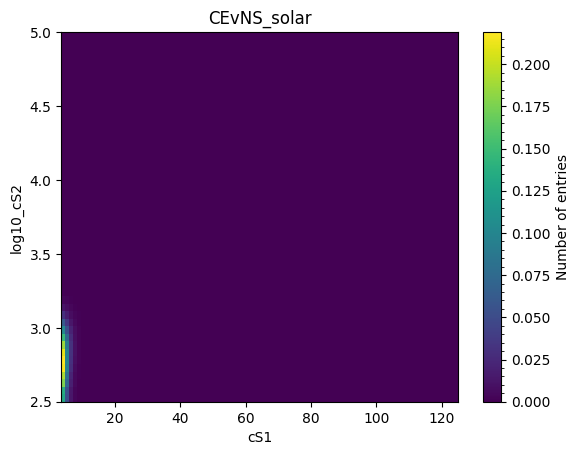

Kr85 0.12428156823125566


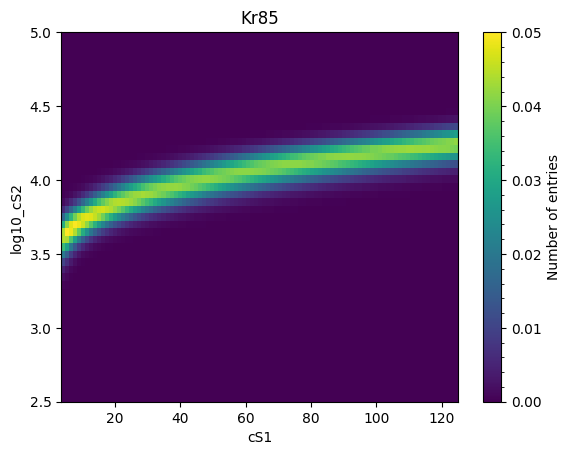

Pb214 0.030300484692539487


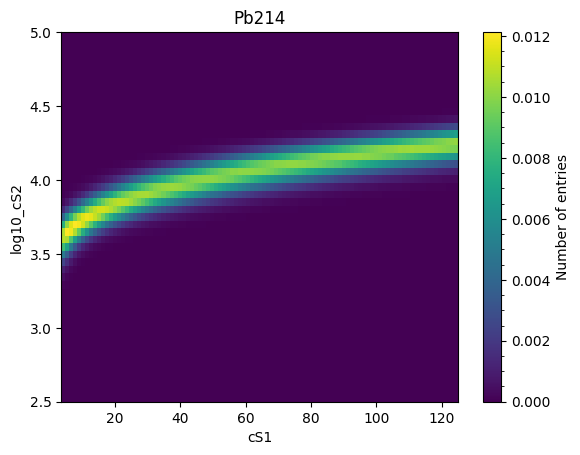

SolarER 0.2162900640507289


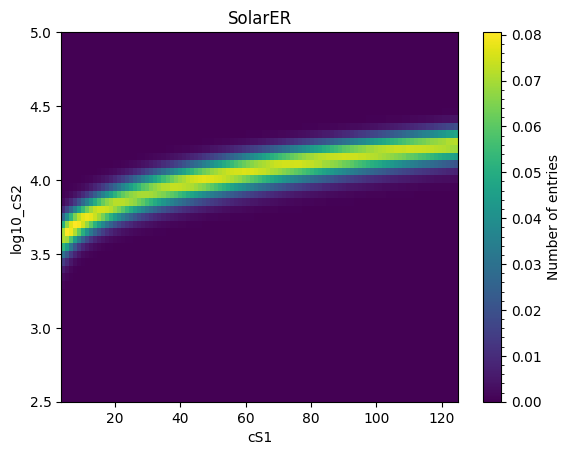

WIMP40 1.9009124278636047


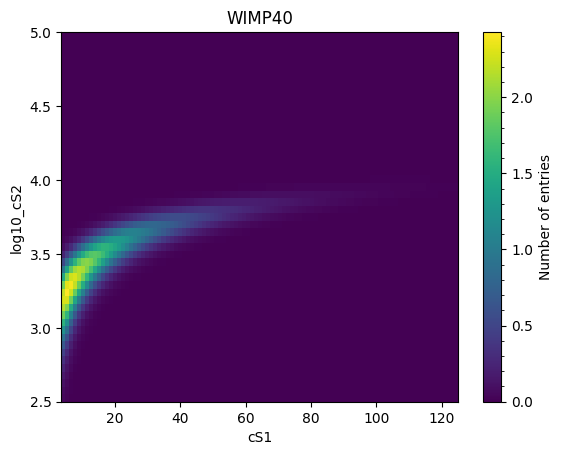

Xe136 0.10955290923647198


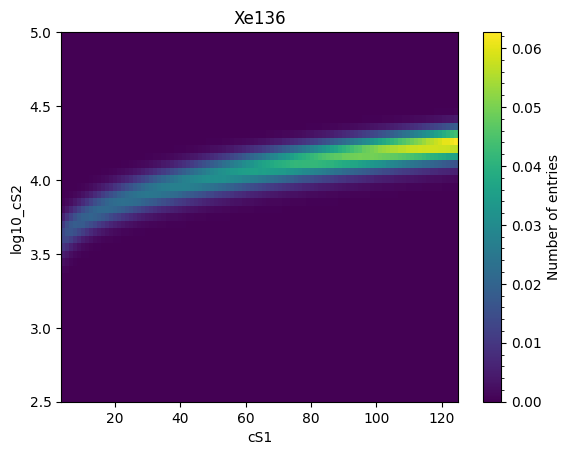

In [37]:
for n in histogram_names:
    plt.clf()
    pdfs[n].plot()
    plt.title(n)
    print(n, pdfs[n].n/140)
    plt.show()

In [39]:
np.linspace(2.5,5, 100)

array([2.5       , 2.52525253, 2.55050505, 2.57575758, 2.6010101 ,
       2.62626263, 2.65151515, 2.67676768, 2.7020202 , 2.72727273,
       2.75252525, 2.77777778, 2.8030303 , 2.82828283, 2.85353535,
       2.87878788, 2.9040404 , 2.92929293, 2.95454545, 2.97979798,
       3.00505051, 3.03030303, 3.05555556, 3.08080808, 3.10606061,
       3.13131313, 3.15656566, 3.18181818, 3.20707071, 3.23232323,
       3.25757576, 3.28282828, 3.30808081, 3.33333333, 3.35858586,
       3.38383838, 3.40909091, 3.43434343, 3.45959596, 3.48484848,
       3.51010101, 3.53535354, 3.56060606, 3.58585859, 3.61111111,
       3.63636364, 3.66161616, 3.68686869, 3.71212121, 3.73737374,
       3.76262626, 3.78787879, 3.81313131, 3.83838384, 3.86363636,
       3.88888889, 3.91414141, 3.93939394, 3.96464646, 3.98989899,
       4.01515152, 4.04040404, 4.06565657, 4.09090909, 4.11616162,
       4.14141414, 4.16666667, 4.19191919, 4.21717172, 4.24242424,
       4.26767677, 4.29292929, 4.31818182, 4.34343434, 4.36868

In [42]:
len(binning["bins"][1])

50